In [11]:
# https://anomaly.io/detect-anomalies-in-correlated-time-series/

# Detecting Anomalies in Correlated Time Series

Day_Index,Date_Range,Segment,Sessions
10/1/15,"Oct 1, 2015 - Jan 23, 2017",New Users,46
10/1/15,"Oct 1, 2015 - Jan 23, 2017",Returning Users,36
10/2/15,"Oct 1, 2015 - Jan 23, 2017",New Users,44
10/2/15,"Oct 1, 2015 - Jan 23, 2017",Returning Users,21
10/3/15,"Oct 1, 2015 - Jan 23, 2017",New Users,12
10/3/15,"Oct 1, 2015 - Jan 23, 2017",Returning Users,15
10/4/15,"Oct 1, 2015 - Jan 23, 2017",New Users,21
10/4/15,"Oct 1, 2015 - Jan 23, 2017",Returning Users,11
10/5/15,"Oct 1, 2015 - Jan 23, 2017",New Users,69
10/5/15,"Oct 1, 2015 - Jan 23, 2017",Returning Users,19


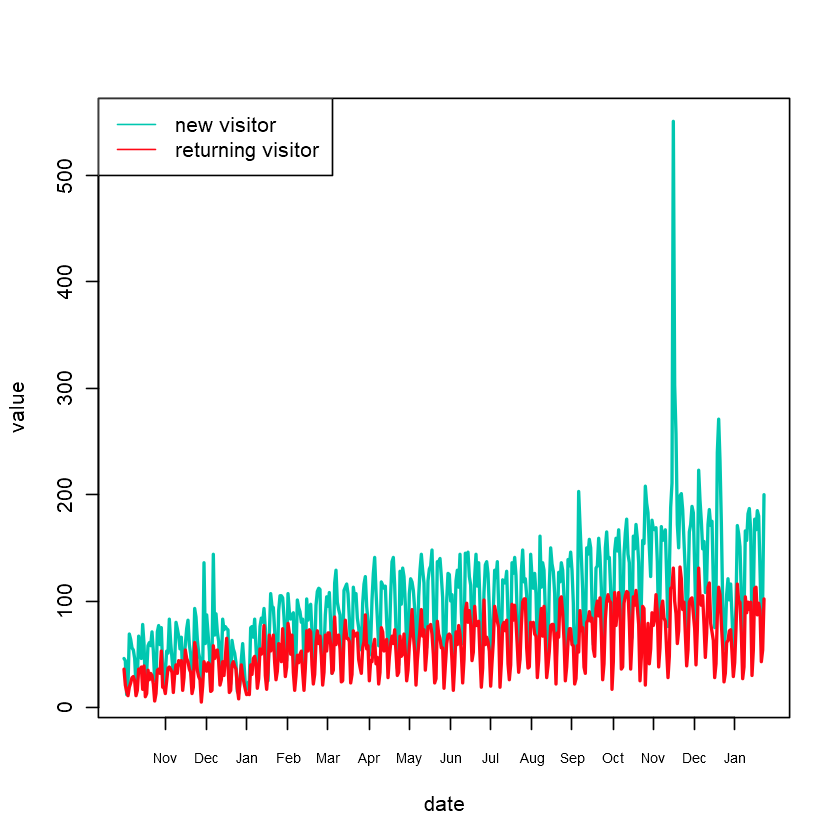

In [4]:

library(tidyverse)
 
# load sample monitoring data file
csv = read.csv("e://new-vs-returning-visitor.csv")

head(csv,10)


#load new visitor
new = filter(csv,Segment=="New Users")
new_data = new[4]$Sessions
new_date = as.Date(lapply(new[1], as.character)$Day_Index, "%m/%d/%y")
new_df = data.frame(date=new_date, value=new_data)
 

#load returning visitor
return = filter(csv,Segment=="Returning Users")
return_data = return[4]$Sessions
return_date = as.Date(lapply(return[1], as.character)$Day_Index, "%m/%d/%y")
return_df = data.frame(date=return_date, value=return_data)
 

#plot
plot_df = function(new_df, return_df = NULL, ylim=c()) {
 plot(value ~ date, new_df, xaxt="n", type="l", col="#00c7b0", ylim=ylim, lwd=2)
 date_axis = new_df$date[1:(length(new_df$date)/30.5)*30.5]+2
 axis(1, date_axis, format(date_axis, "%b"), cex.axis = .7)
 if(!is.null(return_df)) {
 lines(value ~ date, return_df, xaxt="n", type="l", col="#ff0816", lwd=2)
 }
}


plot_df(new_df, return_df)
legend("topleft", c("new visitor","returning visitor"),
      col=c("#00c7b0","#ff0816"), lty=c(1,1))




**Now you have two variables in your R environment:**

-  new_df: new visitors

-  return_df: returning visitors



Autocorrelations of series 'X', by lag

    0 
0.876 

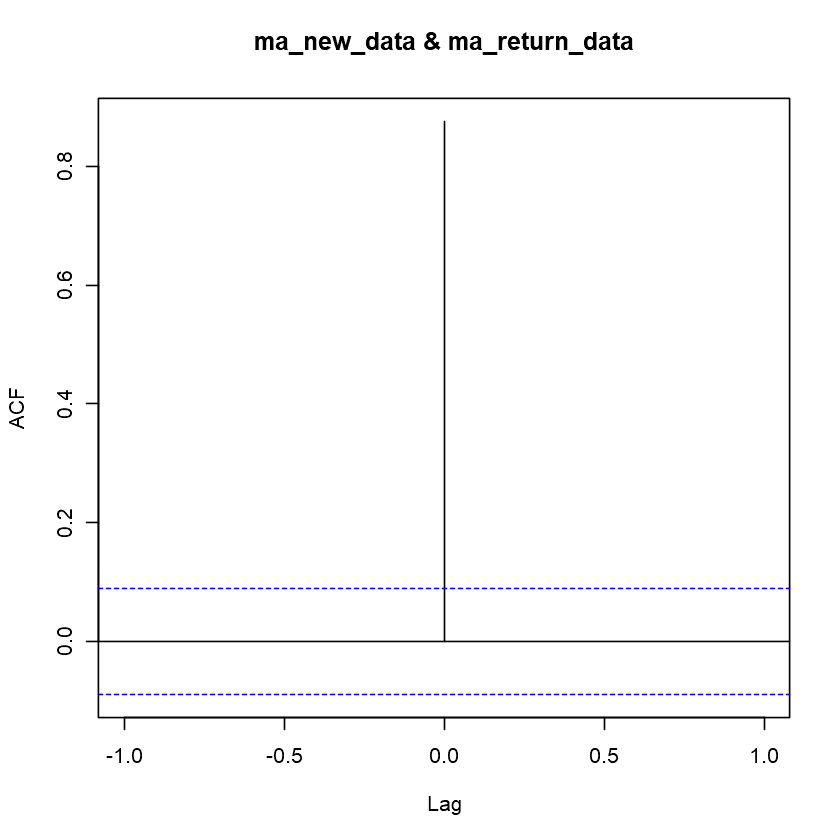

In [5]:

# https://anomaly.io/understand-auto-cross-correlation-normalized-shift/#/cross_correlation

library(stats)
library(forecast)

ma_new_data = ma(new_data, 3)
ma_new_data = ma_new_data[!is.na(ma_new_data)]
ma_return_data = ma(return_data, 3)
ma_return_data = ma_return_data[!is.na(ma_return_data)]
 
corr = ccf(ma_new_data, ma_return_data, lag.max = 0)
corr # display 0.876


Our analysis is based on the time series being correlated, so before going any further, let’s ensure that this is the case. To do so, we need to check using Cross-Correlation. Check this article if you want to Understand the Cross-Correlation algorithm.
As the Moving Average is robust to anomaly we use it to remove potential outliers before computing the correlation. The Cross Correlation Function (CCF) is a very high value of 0.876. Clearly, the time series are correlated.


[1] 1.736529

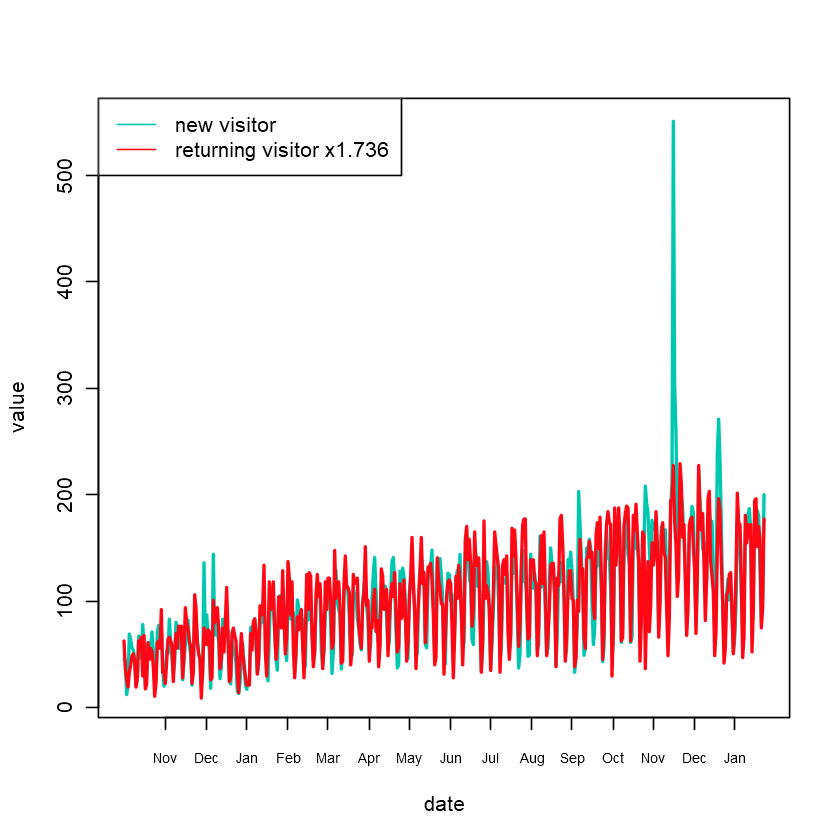

In [6]:

# Step 3: Subtract the Time Series

multi = sum(ma_new_data/ma_return_data)/length(ma_return_data)
multi #display 1.736529
align_return_df = return_df
align_return_df$value = align_return_df$value*multi
plot_df(new_df, align_return_df)
legend("topleft", c("new visitor","returning visitor x1.736"), 
     col=c("#00c7b0","#ff0816"), lty=c(1,1))



We can compute that there are 1.736 times more new visitors than returning visitors. Let’s align the metrics at the same level.


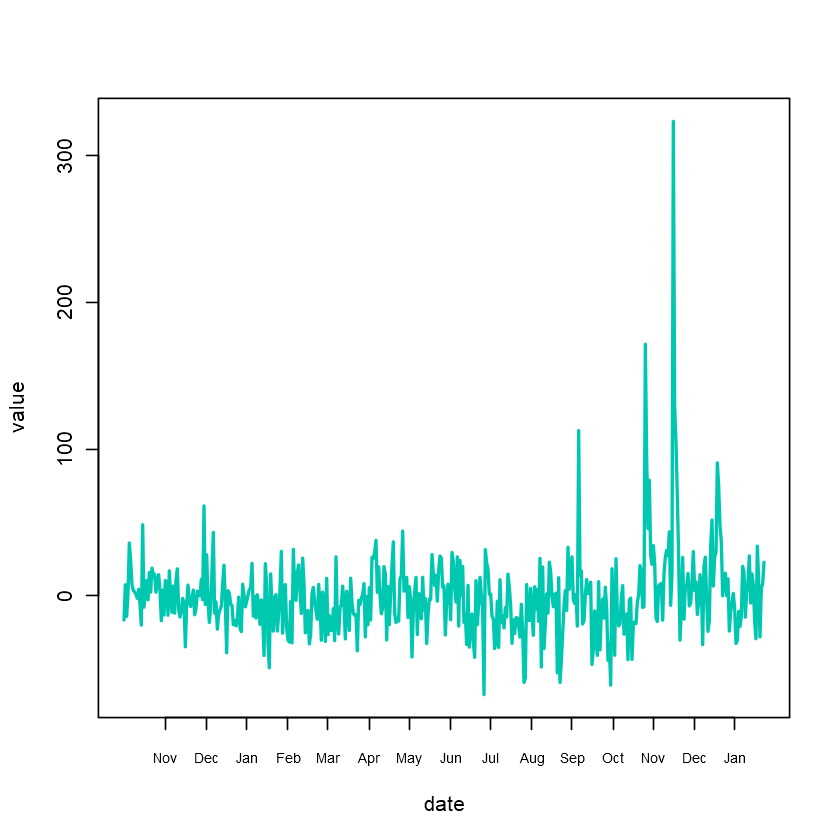

In [7]:

substract = return_df
substract$value = new_df$value - return_df$value*multi
plot_df(substract)


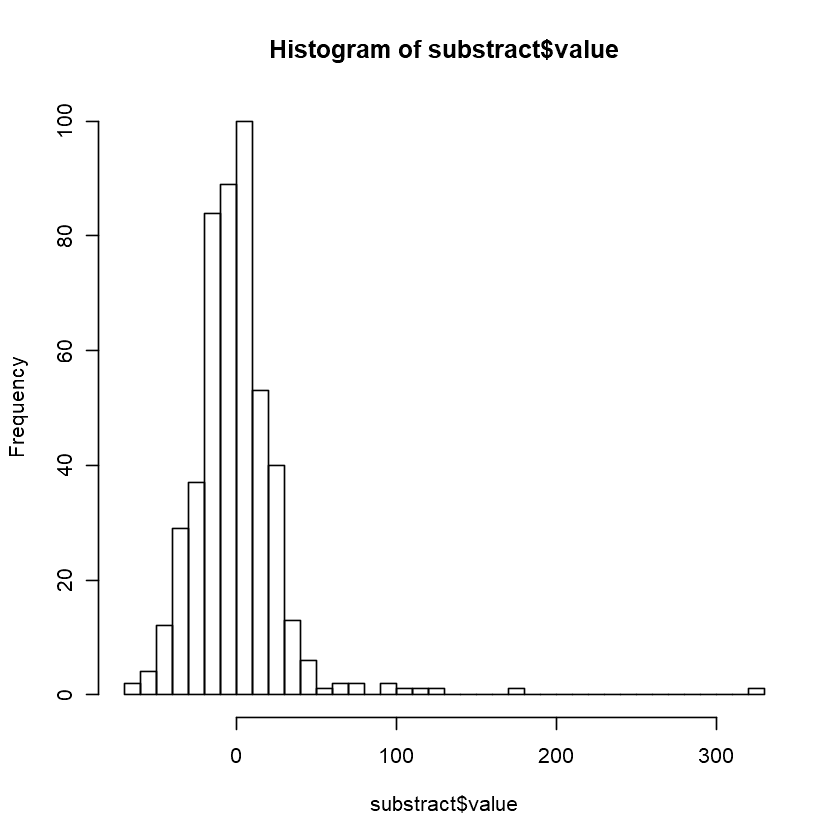

In [8]:

# https://anomaly.io/anomaly-detection-normal-distribution/

# Step 4: Find Outliers in Correlated Time Series

# The resulting signal looks like “noise”. Plotting the histogram show a 
# normally distributed signal. We already know how to detect anomalies 
# in a normally distributed time series using the 3-sigma rule.

hist(substract$value, breaks = 50)



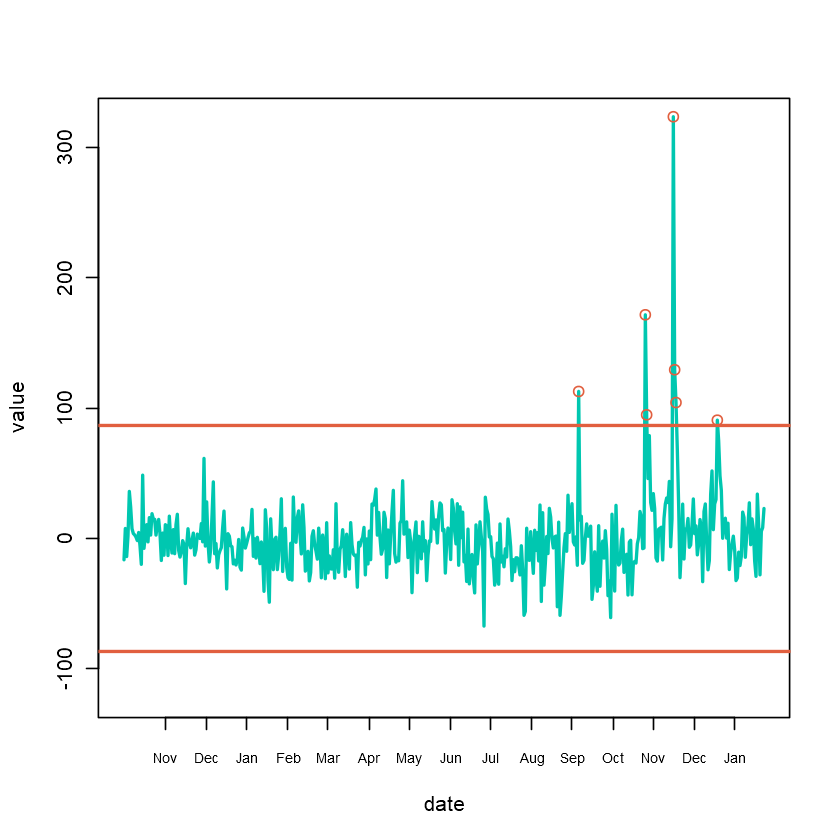

In [10]:

# The 3-sigma rules express that nearly all values are taken to lie within three 
# standard deviations of the mean. Everything outside this range can be treated as anomalous.

#compute 3 sigma minimal & maximal
min = mean(substract$value, na.rm = T) - 3*sd(substract$value, na.rm = T)
max = mean(substract$value, na.rm = T) + 3*sd(substract$value, na.rm = T)
 
# plot metric & limit
plot_df(substract, NULL, c(-120,320))
abline(h=max, col="#e15f3f", lwd=2)
abline(h=min, col="#e15f3f", lwd=2)
 
# plot cercle
position = data.frame(id=seq(1, length(substract$value)), value=substract$value, date=substract$date)
anomalyH = position[position$value > max, ]
anomalyH = anomalyH[!is.na(anomalyH$value), ]
anomalyL = position[position$value < min, ]
anomalyL = anomalyL[!is.na(anomalyL$value), ]
anomaly = data.frame(id=c(anomalyH$id, anomalyL$id), value=c(anomalyH$value, anomalyL$value), date=c(anomalyH$date, anomalyL$date))
anomaly = anomaly[!is.na(anomaly$value), ]
points(x = anomaly$date, y=anomaly$value, col="#e15f3f")



In [ ]:


Conclusion
Looking at the initial retention graph, I was able to spot 1 or 2 anomalies when in reality I had 7. I actually remember back in mid-November when I received the automatic anomaly report. I started digging into the problem, and found out that someone had shared my twitter anomaly review on Hacker News.
